In [13]:
import io
import zipfile
import sqlite3
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt

EJECTIONS_ZIP_URL = "https://www.retrosheet.org/ejections.zip"
DB_NAME = "ejections.db"
TABLE_NAME = "ejections"


DOWNLOAD THE EJECTIONS CSV FILE FROM RETROSHEET

In [2]:
def download_zip(url: str) -> io.BytesIO:
    """
    Download the ZIP file from Retrosheet and return it as a BytesIO object.
    """
    print(f"Downloading: {url}")
    resp = requests.get(url)
    resp.raise_for_status()
    print("Download complete.")
    return io.BytesIO(resp.content)


In [7]:
def read_ejections_csv(zip_bytes: io.BytesIO) -> pd.DataFrame:
    """
    Reads the Retrosheet ejections CSV, which may contain unescaped commas.
    Uses the Python engine for more flexibility in parsing.
    """
    with zipfile.ZipFile(zip_bytes) as zf:
        members = zf.namelist()
        print("Files inside ZIP:", members)

        csv_files = [m for m in members if m.lower().endswith((".csv", ".txt"))]
        if not csv_files:
            raise RuntimeError("No CSV/TXT file found inside ZIP.")

        data_file = csv_files[0]
        print(f"Reading: {data_file}")

        col_names = [
            "game_id",
            "date",
            "game_number",
            "ejectee_id",
            "ejectee_name",
            "ejectee_team",
            "ejectee_role",
            "umpire_id",
            "umpire_name",
            "inning",
            "reason",
        ]

        with zf.open(data_file) as f:
            df = pd.read_csv(
                f,
                header=None,
                names=col_names,
                dtype=str,
                encoding="latin-1",
                engine="python",        # ← critical fix
                on_bad_lines="warn",    # skip badly formatted lines instead of crashing
                sep=",",                # CSV-style
            )

    print("Loaded dataframe:")
    display(df.head())
    print(df.shape)

    return df


In [8]:
def save_to_sqlite(df: pd.DataFrame, db_path: str, table_name: str):
    """
    Save the DataFrame to SQLite as a table.
    """
    db_path_full = os.path.join(os.getcwd(), db_path)

    conn = sqlite3.connect(db_path_full)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()

    print(f"Saved {len(df)} rows to '{table_name}' in database '{db_path_full}'.")


In [9]:
zip_bytes = download_zip(EJECTIONS_ZIP_URL)
df = read_ejections_csv(zip_bytes)
save_to_sqlite(df, DB_NAME, TABLE_NAME)


Downloading: https://www.retrosheet.org/ejections.zip
Download complete.
Files inside ZIP: ['ejections.csv']
Reading: ejections.csv
Loaded dataframe:


C:\Users\Bryan\AppData\Local\Temp\ipykernel_27680\466758907.py:32: ParserWarning: Skipping line 1979: Expected 11 fields in line 1979, saw 12

  df = pd.read_csv(
C:\Users\Bryan\AppData\Local\Temp\ipykernel_27680\466758907.py:32: ParserWarning: Skipping line 1980: Expected 11 fields in line 1980, saw 12

  df = pd.read_csv(


,game_id,date,game_number,ejectee_id,ejectee_name,ejectee_team,ejectee_role,umpire_id,umpire_name,inning,reason
0,GAMEID,DATE,DH,EJECTEE,EJECTEENAME,TEAM,JOB,UMPIRE,UMPIRENAME,INNING,REASON
1,CL6188905250,05/25/1889,NaN,orr-d101,Dave Orr,CL6,P,goldf101,Fred Goldsmith,-1,Call at 3B
2,BL2188905280,05/28/1889,NaN,tuckt103,Tommy Tucker,BL2,P,gaffj801,John Gaffney,-1,Yelling at OF chasing fly
3,WS8188906010,06/01/1889,NaN,ewinb101,Buck Ewing,NY1,P,currw101,Wes Curry,-1,Obscene language
4,WS8188907300,07/30/1889,NaN,ewinb101,Buck Ewing,NY1,P,bakep101,Phil Baker,-1,Call at 1B


(19526, 11)
Saved 19526 rows to 'ejections' in database 'c:\Users\Bryan\dsci510_fall2025_final_project\ejections.db'.


In [10]:
conn = sqlite3.connect(DB_NAME)

example = pd.read_sql("""
SELECT ejectee_name, COUNT(*) AS total_ejections
FROM ejections
GROUP BY ejectee_name
ORDER BY total_ejections DESC
LIMIT 10;
""", conn)

conn.close()

example


,ejectee_name,total_ejections
0,Bobby Cox,165
1,John McGraw,140
2,Leo Durocher,134
3,Frankie Frisch,100
4,Earl Weaver,97
5,Tony LaRussa,93
6,Clark Griffith,87
7,Ron Gardenhire,86
8,Bruce Bochy,86
9,Joe Torre,85


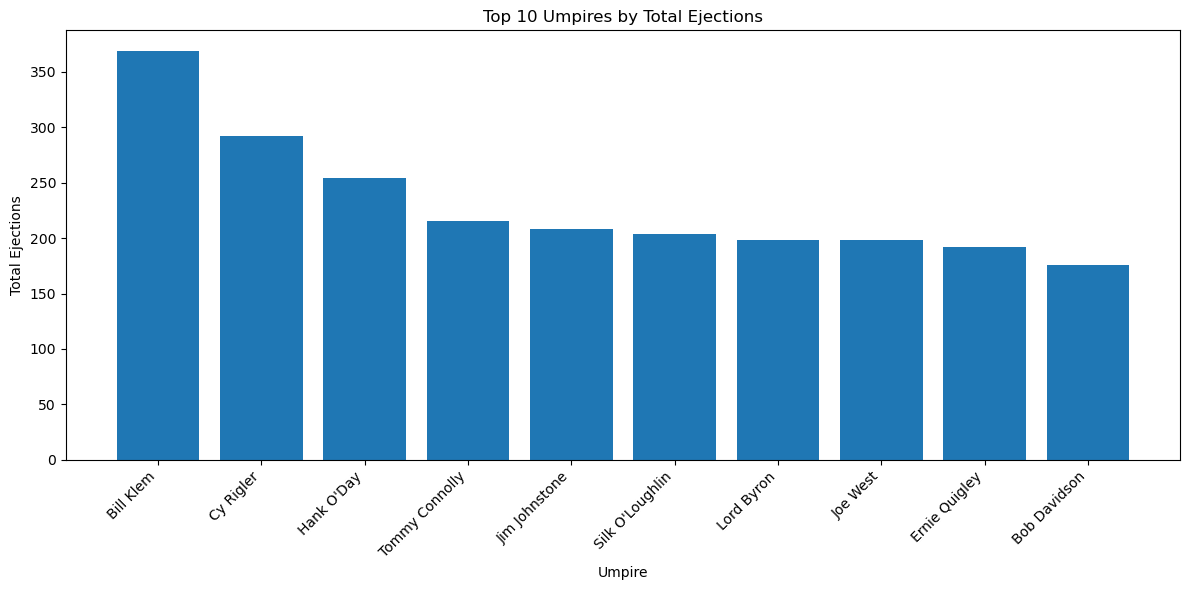

,umpire_name,total_ejections
0,Bill Klem,369
1,Cy Rigler,292
2,Hank O'Day,254
3,Tommy Connolly,215
4,Jim Johnstone,208
5,Silk O'Loughlin,204
6,Lord Byron,198
7,Joe West,198
8,Ernie Quigley,192
9,Bob Davidson,176


In [15]:
# top 10 umpires who have ejected players

# Path to your database 
DB_NAME = "ejections.db"

# 1. Query top 10 umpires by total ejections
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""
top_umpires = pd.read_sql(query, conn)
conn.close()

# 2. Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_umpires["umpire_name"], top_umpires["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections")
plt.title("Top 10 Umpires by Total Ejections")
plt.tight_layout()
plt.show()

# (optional) Also display the data table
top_umpires

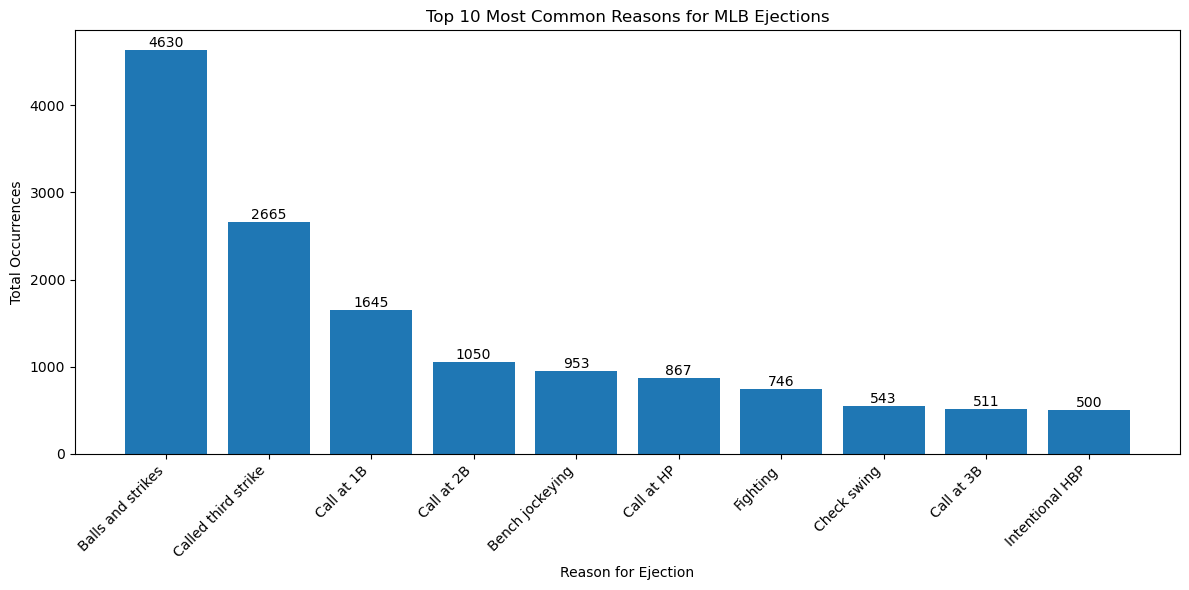

,reason,total_count
0,Balls and strikes,4630
1,Called third strike,2665
2,Call at 1B,1645
3,Call at 2B,1050
4,Bench jockeying,953
5,Call at HP,867
6,Fighting,746
7,Check swing,543
8,Call at 3B,511
9,Intentional HBP,500


In [17]:
# 1. Query: top 10 ejection reasons
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE reason IS NOT NULL AND reason <> ''
GROUP BY reason
ORDER BY total_count DESC
LIMIT 10;
"""
top_reasons = pd.read_sql(query, conn)
conn.close()

# 2. Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(top_reasons["reason"], top_reasons["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Reason for Ejection")
plt.ylabel("Total Occurrences")
plt.title("Top 10 Most Common Reasons for MLB Ejections")
plt.tight_layout()

# 3. Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()

# Show the table too
top_reasons

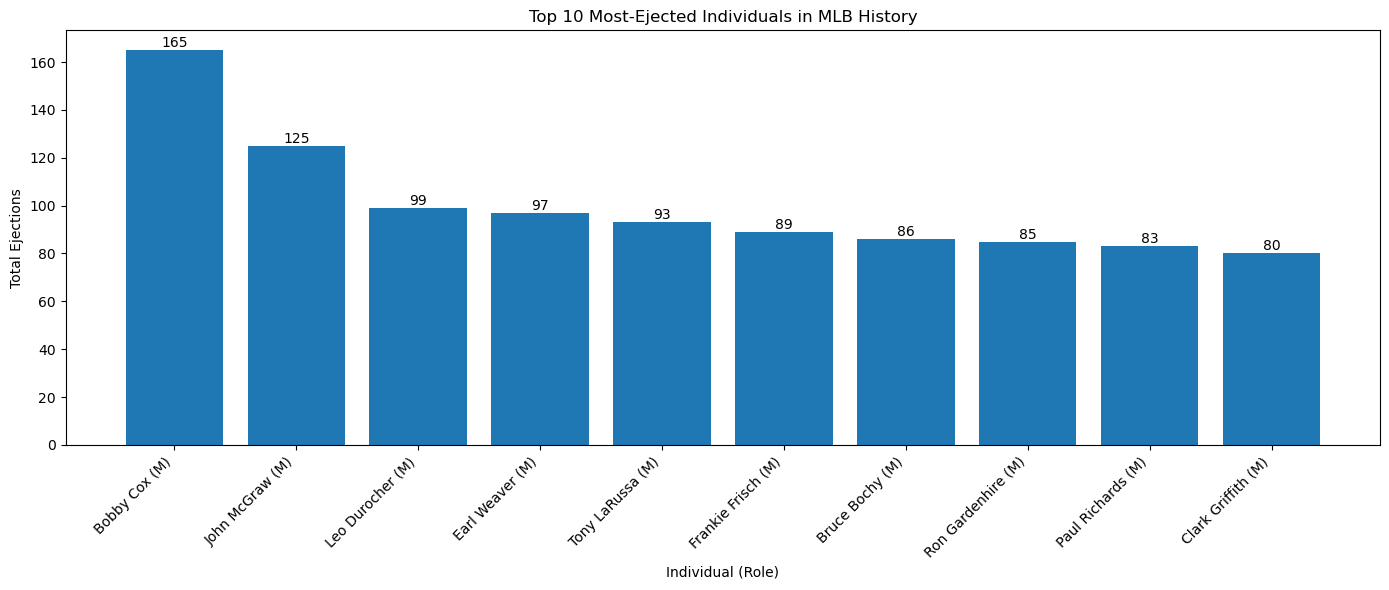

,ejectee_name,ejectee_role,total_ejections,label
0,Bobby Cox,M,165,Bobby Cox (M)
1,John McGraw,M,125,John McGraw (M)
2,Leo Durocher,M,99,Leo Durocher (M)
3,Earl Weaver,M,97,Earl Weaver (M)
4,Tony LaRussa,M,93,Tony LaRussa (M)
5,Frankie Frisch,M,89,Frankie Frisch (M)
6,Bruce Bochy,M,86,Bruce Bochy (M)
7,Ron Gardenhire,M,85,Ron Gardenhire (M)
8,Paul Richards,M,83,Paul Richards (M)
9,Clark Griffith,M,80,Clark Griffith (M)


In [20]:
# 1. Query: top 10 ejectees with their roles
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    ejectee_name,
    ejectee_role,
    COUNT(*) AS total_ejections
FROM ejections
WHERE ejectee_name IS NOT NULL AND ejectee_name <> ''
GROUP BY ejectee_name, ejectee_role
ORDER BY total_ejections DESC
LIMIT 10;
"""
top_players = pd.read_sql(query, conn)
conn.close()

# Construct label: "Name (Role)"
top_players["label"] = top_players["ejectee_name"] + " (" + top_players["ejectee_role"] + ")"

# 2. Plot bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(top_players["label"], top_players["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Individual (Role)")
plt.ylabel("Total Ejections")
plt.title("Top 10 Most-Ejected Individuals in MLB History")
plt.tight_layout()

# 3. Add numbers above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()

# Show the table
top_players

       ejectee_name  total_ejections
0      Johnny Evers               63
1  Heinie Zimmerman               46
2      Jim Piersall               36
3   Roger Bresnahan               35
4       Bill Dahlen               34
5       Larry Doyle               33
6    Gary Sheffield               33
7         Red Dooin               32
8        Dan McGann               31
9      Jimmy Austin               29


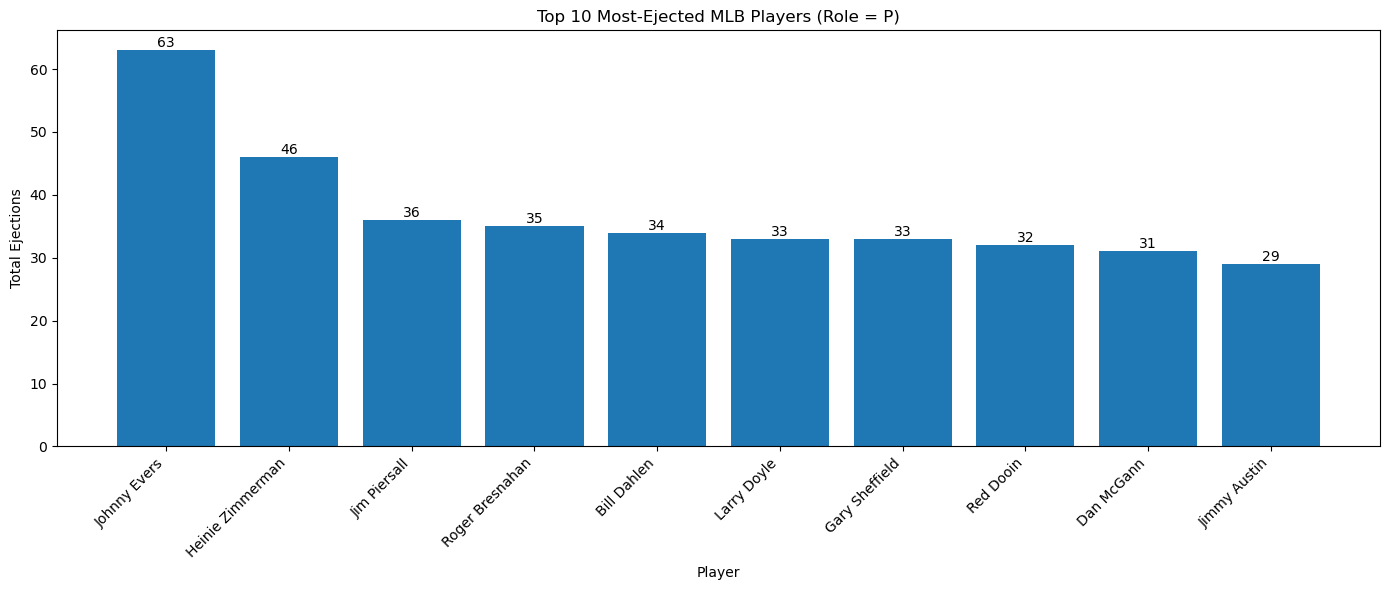

In [23]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DB_NAME = "ejections.db"   # make sure this matches your filename

# 1. Query: top 10 ejected players (role code 'P')
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    ejectee_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE ejectee_role = 'P'
  AND ejectee_name IS NOT NULL 
  AND ejectee_name <> ''
GROUP BY ejectee_name
ORDER BY total_ejections DESC
LIMIT 10;
"""
top_players = pd.read_sql(query, conn)
conn.close()

print(top_players)  # optional: inspect the table

# 2. Bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(top_players["ejectee_name"], top_players["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Player")
plt.ylabel("Total Ejections")
plt.title("Top 10 Most-Ejected MLB Players (Role = P)")
plt.tight_layout()

# 3. Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


Video review was added to the MLB after 08/28/2008

          umpire_name  total_ejections
0            Joe West               64
1  Hunter Wendelstedt               62
2       Vic Carapazza               59
3         Dan Bellino               55
4          Bill Welke               52
5         Jeff Nelson               51
6        Doug Eddings               50
7         Will Little               48
8         Greg Gibson               48
9      Mike Estabrook               47


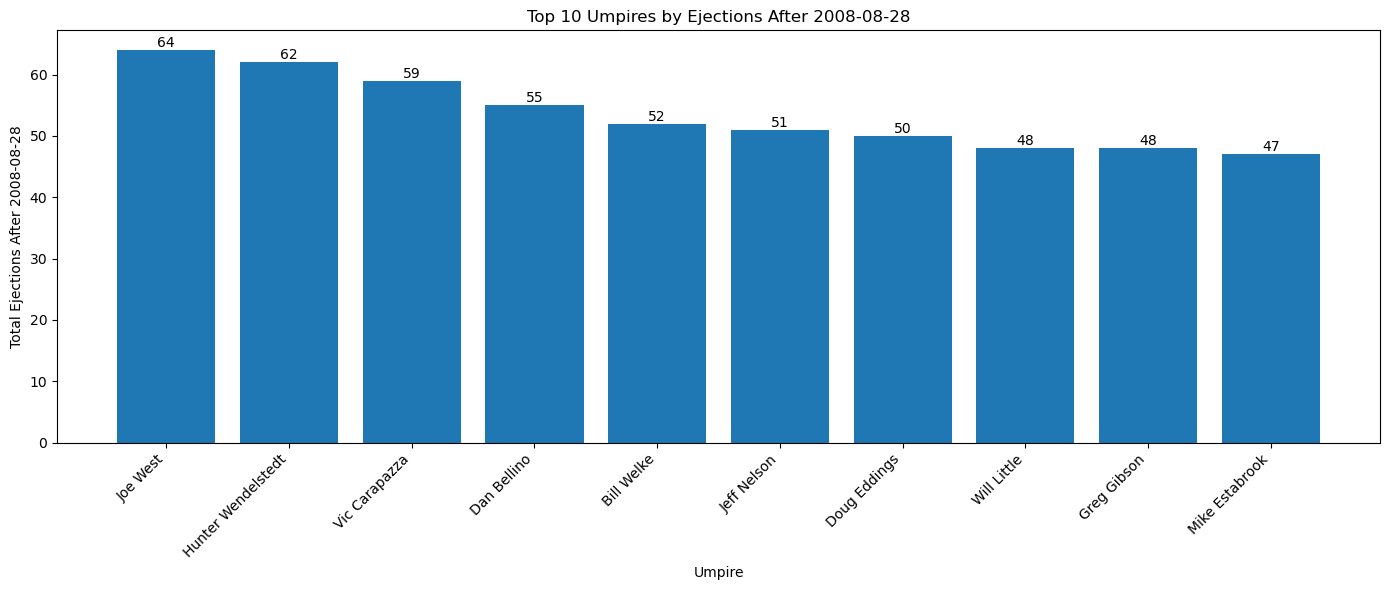

In [26]:


# 1. Query: top 10 umpires after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE date <> 'DATE'  -- skip header row
  AND date(
        substr(date,7,4) || '-' ||  -- YYYY
        substr(date,1,2) || '-' ||  -- MM
        substr(date,4,2)            -- DD
      ) > date('2008-08-28')
  AND umpire_name IS NOT NULL
  AND umpire_name <> ''
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""

top_umpires_after = pd.read_sql(query, conn)
conn.close()

print(top_umpires_after)  # optional: inspect table

# 2. Bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(top_umpires_after["umpire_name"], top_umpires_after["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections After 2008-08-28")
plt.title("Top 10 Umpires by Ejections After 2008-08-28")
plt.tight_layout()

# 3. Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [34]:
# 1. Query: top 10 umpires between 2015–2022
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE date <> 'DATE'  -- skip header row
  AND umpire_name IS NOT NULL
  AND umpire_name <> ''
  AND date(
        substr(date,7,4) || '-' ||  -- YYYY
        substr(date,1,2) || '-' ||  -- MM
        substr(date,4,2)            -- DD
      ) BETWEEN date('2015-01-01') AND date('2022-12-31')
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""

top_umpires_2015_2022 = pd.read_sql(query, conn)
conn.close()


In [37]:
top_umpires_2015_2022.to_csv("top_umpires_2015_2022.csv", index=False)


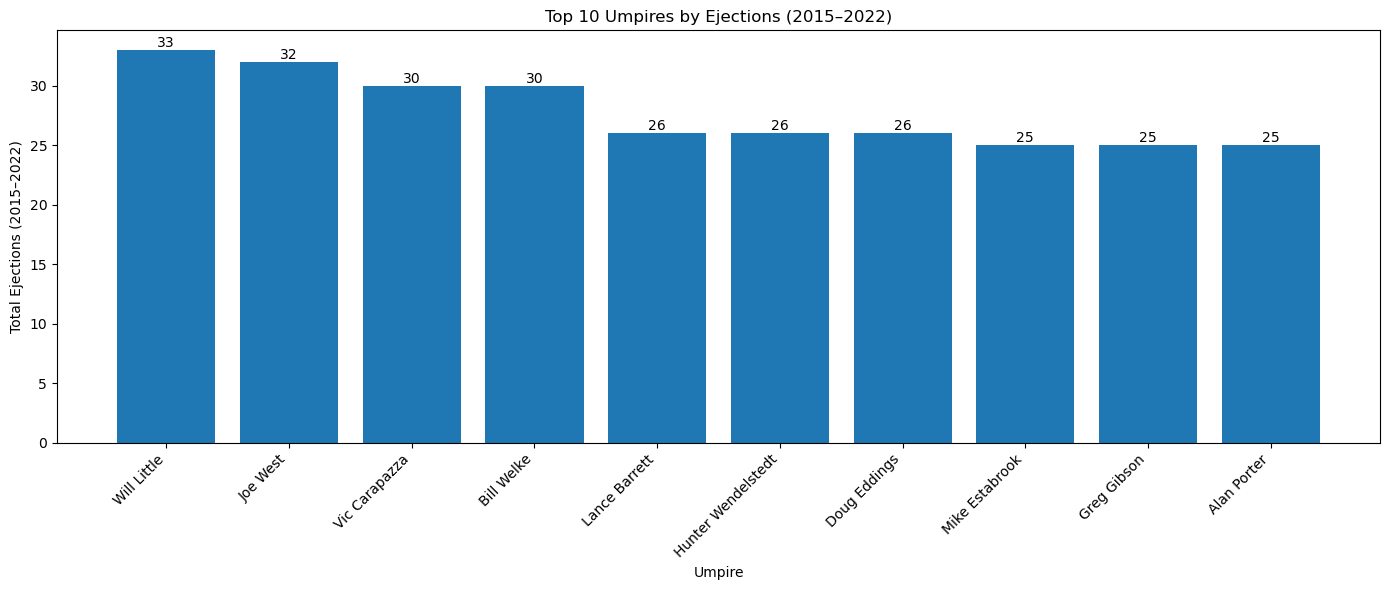

In [35]:
plt.figure(figsize=(14, 6))
bars = plt.bar(top_umpires_2015_2022["umpire_name"],
               top_umpires_2015_2022["total_ejections"])

plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections (2015–2022)")
plt.title("Top 10 Umpires by Ejections (2015–2022)")
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [27]:
DB_NAME = "ejections.db"

# 1. Query reasons Joe West issued ejections after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE umpire_name = 'Joe West'
  AND reason IS NOT NULL 
  AND reason <> ''
  AND date <> 'DATE'
  AND date(
        substr(date,7,4) || '-' || 
        substr(date,1,2) || '-' ||
        substr(date,4,2)
      ) > date('2008-08-28')
GROUP BY reason
ORDER BY total_count DESC;
"""

west_reasons = pd.read_sql(query, conn)
conn.close()

west_reasons

,reason,total_count
0,Fighting,7
1,Balls and strikes,7
2,Called third strike,6
3,Call at 1B,4
4,Bench-clearing altercation,3
5,Interference non-call,2
6,Interference call,2
7,Intentional hit by pitch,2
8,Intentional HBP,2
9,Home run replay ruling,2


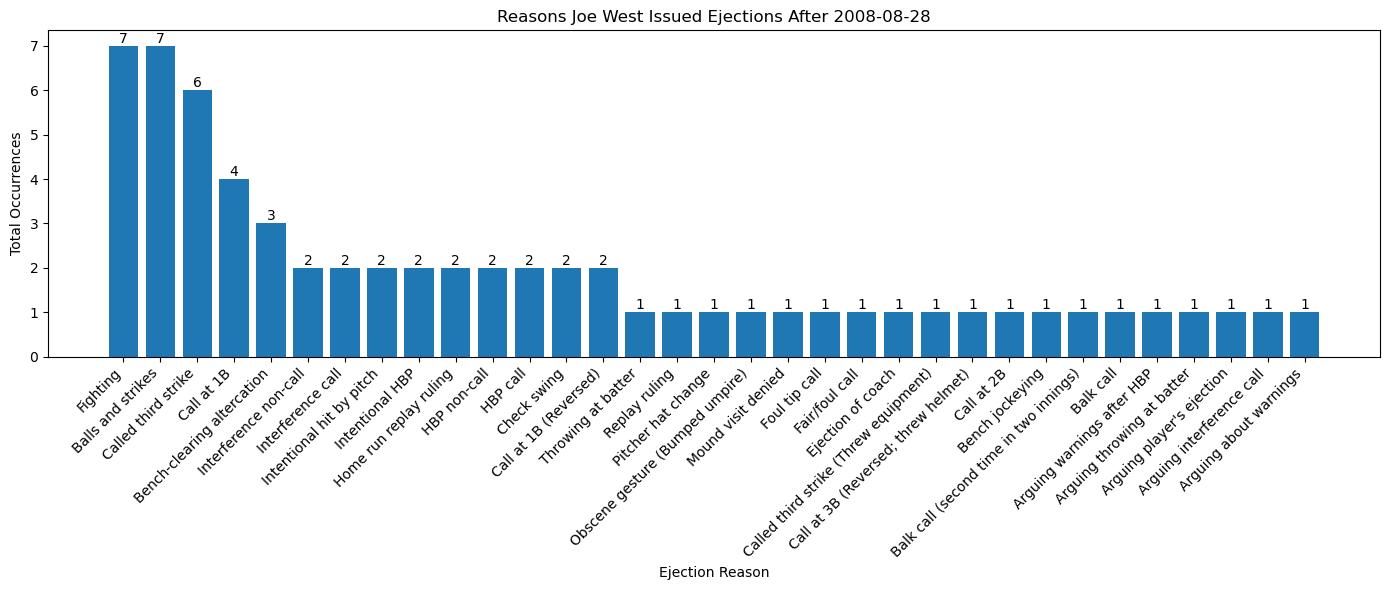

In [28]:
plt.figure(figsize=(14, 6))
bars = plt.bar(west_reasons["reason"], west_reasons["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ejection Reason")
plt.ylabel("Total Occurrences")
plt.title("Reasons Joe West Issued Ejections After 2008-08-28")
plt.tight_layout()

# Add number labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [31]:
# 1. Query: top 10 reasons after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE reason IS NOT NULL 
  AND reason <> ''
  AND date <> 'DATE'
  AND date(
        substr(date,7,4) || '-' || 
        substr(date,1,2) || '-' || 
        substr(date,4,2)
      ) > date('2008-08-28')
GROUP BY reason
ORDER BY total_count DESC
LIMIT 10;
"""

top10_reasons_after = pd.read_sql(query, conn)
conn.close()

top10_reasons_after

,reason,total_count
0,Balls and strikes,849
1,Called third strike,663
2,Check swing,197
3,Intentional HBP,118
4,Fighting,97
5,Call at 1B,84
6,Replay ruling,50
7,Call at 2B,48
8,Balk call,47
9,Fair/foul call,40


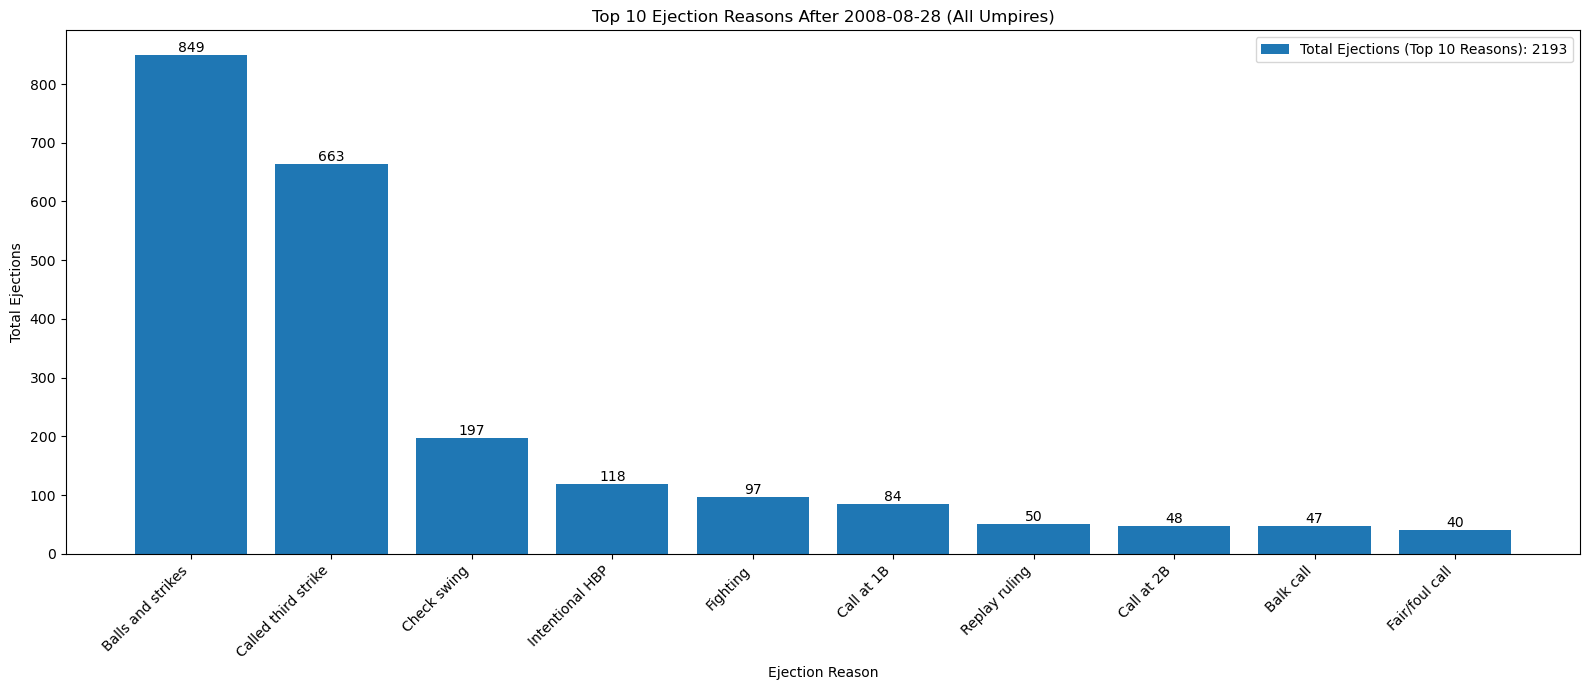

In [33]:
# Calculate total ejections in the top 10
total_top10 = top10_reasons_after["total_count"].sum()

plt.figure(figsize=(16, 7))
bars = plt.bar(top10_reasons_after["reason"], top10_reasons_after["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ejection Reason")
plt.ylabel("Total Ejections")
plt.title("Top 10 Ejection Reasons After 2008-08-28 (All Umpires)")

# Add legend showing total ejections in the dataset
plt.legend([f"Total Ejections (Top 10 Reasons): {total_top10}"])

plt.tight_layout()

# Add number labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()
